In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [10]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
file_path = '/content/gdrive/MyDrive/Project'
if os.path.exists(file_path):
  print("Success")
csv_path = os.path.join(file_path, 'creditcard.csv')

Success


In [11]:
import tensorflow as tf
import numpy as np

In [12]:
df = pd.read_csv(csv_path)
print(df.columns)
df.head(5)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [13]:
# We will introduce a log of the Amount column, use the column in modelling and drop the original Amount column
# However in order to do this, there are some values with 0 in Amount and Log(0) is infinity and hence we add a very small
# negligible amount to the log to avoid this infinity error

adjustments = 0.001

df['LogAmount'] = np.log(df['Amount'] + adjustments)

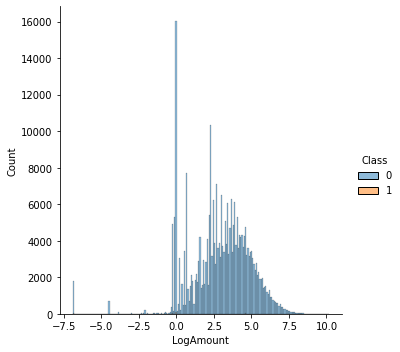

In [14]:
sns.displot(x="LogAmount", hue='Class', data=df)

In [16]:
# Dropping Columns like Time, Amount

df = df.drop(labels=["Time", "Amount"], axis=1)

In [17]:
# Extracting features and target

features = df.drop(labels=['Class'], axis = 1)
target = df['Class']

In [18]:
# Perform feature scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
features = sc.fit_transform(features)
features

array([[-0.69424232, -0.04407492,  1.6727735 , ...,  0.33089162,
        -0.06378115,  1.02091976],
       [ 0.60849633,  0.16117592,  0.1097971 , ..., -0.02225568,
         0.04460752, -0.96466543],
       [-0.69350046, -0.81157783,  1.16946849, ..., -0.13713686,
        -0.18102083,  1.47975471],
       ...,
       [ 0.98002374, -0.18243372, -2.14320514, ...,  0.01103672,
        -0.0804672 ,  0.63036959],
       [-0.12275539,  0.32125034,  0.46332013, ...,  0.26960398,
         0.31668678, -0.31596056],
       [-0.27233093, -0.11489898,  0.46386564, ..., -0.00598394,
         0.04134999,  1.20464259]])

In [19]:
# Perform the training, validation and test splits - We do stratified Sampling

from sklearn.model_selection import train_test_split
features_train, features_test, target_train, target_test = train_test_split(
                                                              features, target, test_size=0.3, 
                                                              random_state=101, stratify=target
                                                            )

features_train, features_validation, target_train, target_validation = train_test_split(
                                                                          features_train, target_train,
                                                                          test_size=0.3, random_state=101, 
                                                                          stratify=target_train
                                                                        )


In [23]:
# Define the Model Constants

INPUT_SHAPE = (features_train.shape[1], )

OUTPUT_UNITS = 1
HIDDEN_UNITS = 16
ACTIVATION_HIDDEN = tf.keras.activations.relu
ACTIVATION_OUTPUT = tf.keras.activations.sigmoid
LEARNING_RATE = 1e-3
OPTIMIZER = tf.keras.optimizers.Adam(LEARNING_RATE)
LOSS_FUNCTION = tf.keras.losses.BinaryCrossentropy()
DROPOUT_RATE = 0.5

EPOCHS = 100
BATCH_SIZE = 2048

In [24]:
# Define the Metrics

METRICS = [tf.keras.metrics.TruePositives(name='tp'),
          tf.keras.metrics.FalsePositives(name='fp'),
          tf.keras.metrics.TrueNegatives(name='tn'),
          tf.keras.metrics.FalseNegatives(name='fn'), 
          tf.keras.metrics.BinaryAccuracy(name='accuracy'),
          tf.keras.metrics.Precision(name='precision'),
          tf.keras.metrics.Recall(name='recall'),
          tf.keras.metrics.AUC(name='auc')]

In [25]:
# Function which will build and compile the model

def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = tf.keras.models.Sequential([
           tf.keras.layers.Dense(input_shape=INPUT_SHAPE, units=HIDDEN_UNITS, activation=ACTIVATION_HIDDEN),
           tf.keras.layers.Dropout(DROPOUT_RATE),
           tf.keras.layers.Dense(units=OUTPUT_UNITS, activation=ACTIVATION_OUTPUT, bias_initializer=output_bias)
       ])
    model.compile(optimizer=OPTIMIZER, loss=LOSS_FUNCTION, metrics=metrics)
    return model

In [26]:
# Lets build the model and see the mmodel summary

model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                480       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________


In [27]:
# we will now train the model on training and validation data

epochs_history = model.fit(features_train, target_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                          validation_data=(features_validation, target_validation),
                          verbose=1)

Epoch 1/100
69/69 [==============================] - 4s 24ms/step - loss: 0.3208 - tp: 51.6286 - fp: 5846.2857 - tn: 66646.2429 - fn: 80.3571 - accuracy: 0.9069 - precision: 0.0082 - recall: 0.4025 - auc: 0.6186 - val_loss: 0.1262 - val_tp: 34.0000 - val_fp: 87.0000 - val_tn: 59620.0000 - val_fn: 69.0000 - val_accuracy: 0.9974 - val_precision: 0.2810 - val_recall: 0.3301 - val_auc: 0.7859
Epoch 2/100
69/69 [==============================] - 1s 12ms/step - loss: 0.1461 - tp: 33.9000 - fp: 959.1143 - tn: 71540.8429 - fn: 90.6571 - accuracy: 0.9837 - precision: 0.0293 - recall: 0.2573 - auc: 0.6706 - val_loss: 0.0692 - val_tp: 39.0000 - val_fp: 12.0000 - val_tn: 59695.0000 - val_fn: 64.0000 - val_accuracy: 0.9987 - val_precision: 0.7647 - val_recall: 0.3786 - val_auc: 0.8289
Epoch 3/100
69/69 [==============================] - 1s 11ms/step - loss: 0.0887 - tp: 40.1714 - fp: 188.4857 - tn: 72312.0714 - fn: 83.7857 - accuracy: 0.9961 - precision: 0.1707 - recall: 0.3454 - auc: 0.7611 - val_

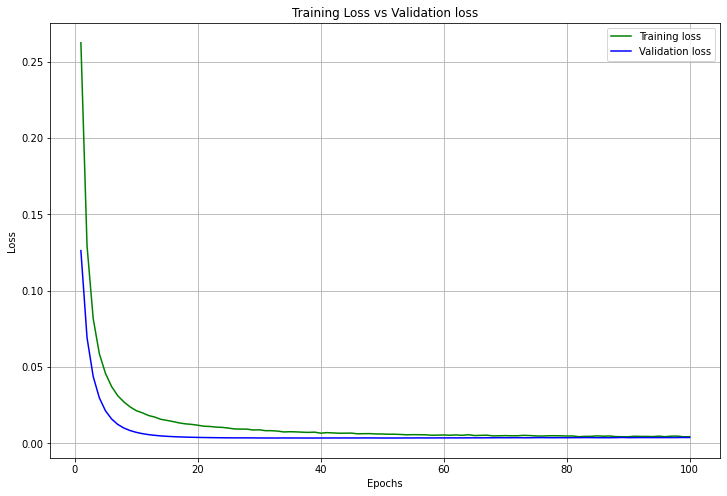

In [28]:
plt.figure(figsize=(12, 8))

loss_train = epochs_history.history['loss']
loss_val = epochs_history.history['val_loss']

epochs = range(1,101)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='Validation loss')
plt.title('Training Loss vs Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

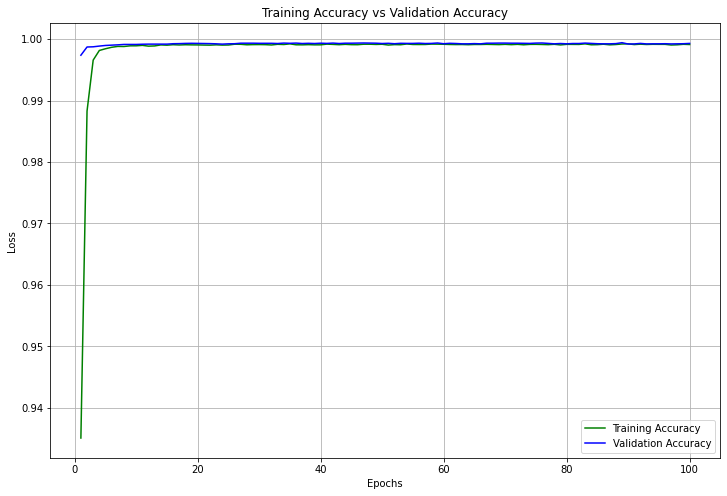

In [29]:
plt.figure(figsize=(12, 8))

loss_train = epochs_history.history['accuracy']
loss_val = epochs_history.history['val_accuracy']

epochs = range(1,101)
plt.plot(epochs, loss_train, 'g', label='Training Accuracy')
plt.plot(epochs, loss_val, 'b', label='Validation Accuracy')
plt.title('Training Accuracy vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [30]:
# Let us run the predictions

target_predictions = model.predict(features_test)

# Let us visualize the Confusion Matrix and detail out some key metrices including classification report

from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score, balanced_accuracy_score

def plot_cm(labels, predictions, threshold=0.5):
    cm = confusion_matrix(labels, predictions > threshold)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion Matrix %0.2f" %threshold)
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    
    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))
    print("\n")
    print("F1-Score")
    print(f1_score(target_test, target_predictions > threshold))
    print("\n")
    print("Accuracy Score")
    print(accuracy_score(target_test, target_predictions > threshold))
    print("\n")
    print("Balanced Accuracy Score")
    print(balanced_accuracy_score(target_test, target_predictions > threshold))
    print("\n")
    print("Classification Report")
    print(classification_report(target_test, target_predictions > threshold))

Legitimate Transactions Detected (True Negatives):  85283
Legitimate Transactions Incorrectly Detected (False Positives):  12
Fraudulent Transactions Missed (False Negatives):  43
Fraudulent Transactions Detected (True Positives):  105
Total Fraudulent Transactions:  148


F1-Score
0.7924528301886792


Accuracy Score
0.9993562960102056


Balanced Accuracy Score
0.8546593856298411


Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.90      0.71      0.79       148

    accuracy                           1.00     85443
   macro avg       0.95      0.85      0.90     85443
weighted avg       1.00      1.00      1.00     85443



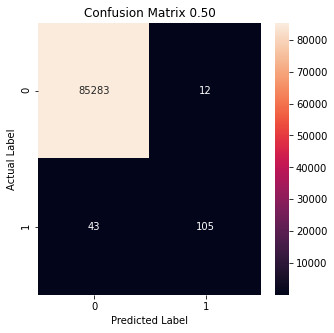

In [31]:
# Now use the function to plot the confusion matrix

plot_cm (target_test, target_predictions)